### Time Series Exploratory Data Analysis (EDA)

A time series is simply a series of data points ordered in time. In a time series, time is often the independent variable and the goal is usually to make a **forecast** for the future.

However, there are other aspects that come into play when dealing with time series. Namely:
- Is it **stationary**? Stationarity is an important characteristic of time series. A time series is said to be
stationary if its statistical properties do not change over time. In other words, it has
constant mean and variance, and covariance is independent of time. We'll study what these concepts represent when we get into statistics. For now just think of them as point estimates of a distribution of numbers. Often, stock prices are ***not a stationary process***, since we might see a growing trend, or
its volatility might increase over time (meaning that variance is changing). Ideally, we want to have a stationary time series for modelling. Of course, not all of them are stationary, but we can often make different transformations to make them stationary. [Dickey-Fuller](https://en.wikipedia.org/wiki/Dickey%E2%80%93Fuller_test) is the statistical test
that we run to determine if a time series is stationary or not. If you Coop for Wall Street or get a job as quant, you'll be running this test *all the time*.


- Is the target variable **autocorrelated**? Autocorrelation is the similarity between observations as a function of the
time lag between them


- Is there a **seasonality**? Seasonality refers to periodic fluctuations. For example, electricity consumption is high
during the day and low during night, or online sales increase during Christmas before slowing down again. seasonality can also be derived from an autocorrelation plot if it has a
sinusoidal shape. Simply look at the period, and it gives the length of the season

First, we import libraries that will be helpful throughout our analysis. 

Then, we import a dataset.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

data = pd.read_csv('amazon_stock_prices_sample.csv', index_col=['Date'], parse_dates=['Date'])
data.head(10)

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2017-01-19,810.000000,813.510010,807.320007,809.039978,809.039978,2540800
2017-01-20,815.280029,816.020020,806.260010,808.330017,808.330017,3376200
2017-01-23,806.799988,818.500000,805.080017,817.880005,817.880005,2797500
2017-01-24,822.000000,823.989990,814.500000,822.440002,822.440002,2971700
2017-01-25,825.789978,837.419983,825.289978,836.520020,836.520020,3922600
2017-01-26,835.530029,843.840027,833.000000,839.150024,839.150024,3586300
2017-01-27,839.000000,839.700012,829.440002,835.770020,835.770020,2998700
2017-01-30,833.000000,833.500000,816.380005,830.380005,830.380005,3747300
2017-01-31,823.750000,826.989990,819.559998,823.479980,823.479980,3137200


Let's plot the closing price:

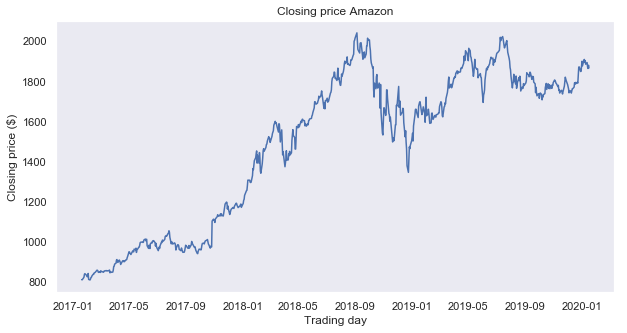

In [3]:
# Plot closing price

plt.figure(figsize=(10, 5))
plt.plot(data.Close)
plt.title('Closing price Amazon')
plt.ylabel('Closing price ($)')
plt.xlabel('Trading day')
plt.grid(False)
plt.show()

Clearly, you see that this is not a stationary process, and it is hard to tell if there is some
kind of seasonality.

### Moving average
The moving average model is probably the most naive approach to time series
modelling. This model simply states that the next observation is the mean of all past
observations.

Although simple, this model might be surprisingly good and it represents a good starting
point. 

Otherwise, the moving average can be used to identify interesting trends in the data. We
can define a window to apply the moving average model to smooth the time series, and
highlight different trends.

Let’s use the moving average model to smooth our time series. For that, we will use a
helper function that will run the moving average model on a specified time window and
it will plot the result smoothed curve:

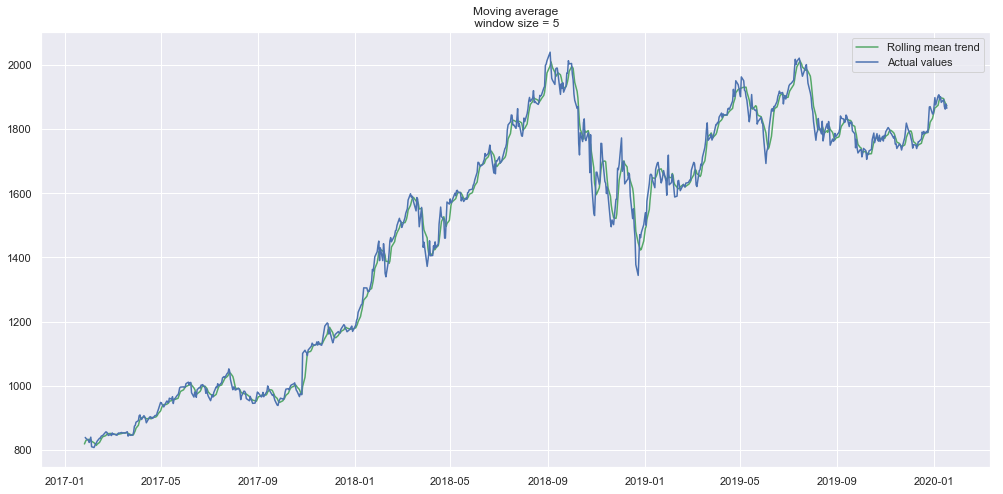

In [4]:
def plot_moving_average(series, window, plot_intervals=False, scale=1.96):
    rolling_mean = series.rolling(window=window).mean()
 
    plt.figure(figsize=(17,8))
    plt.title('Moving average\n window size = {}'.format(window))
    plt.plot(rolling_mean, 'g', label='Rolling mean trend')

    #Plot confidence intervals for smoothed values
    if plot_intervals:
        mae = mean_absolute_error(series[window:], rolling_mean[window:])
        deviation = np.std(series[window:] - rolling_mean[window:])
        lower_bound = rolling_mean - (mae + scale * deviation)
        upper_bound = rolling_mean + (mae + scale * deviation)
        plt.plot(upper_bound, 'r--', label='Upper bound / Lower bound')
        plt.plot(lower_bound, 'r--')

    plt.plot(series[window:], label='Actual values')
    plt.legend(loc='best')
    plt.grid(True)

#Smooth by the previous 5 days (by week)
plot_moving_average(data.Close, 5)

#Smooth by the previous month (30 days)
#plot_moving_average(data.CLOSE, 30)

#Smooth by previous quarter (90 days)
#plot_moving_average(data.CLOSE, 90, plot_intervals=True)

As you can see, we can hardly see a trend, because it is too close to actual curve. Let’s see
the result of smoothing by the previous month, and previous quarter:

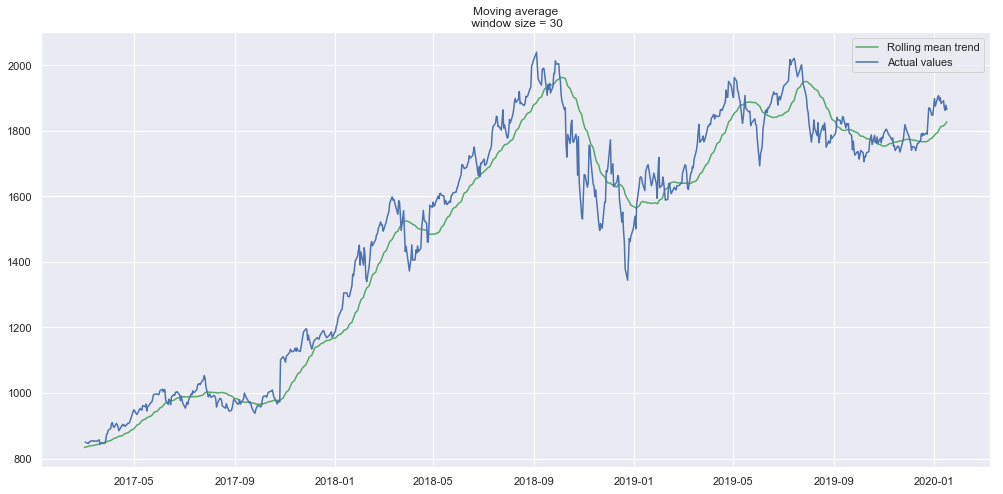

In [5]:
plot_moving_average(data.Close, 30)

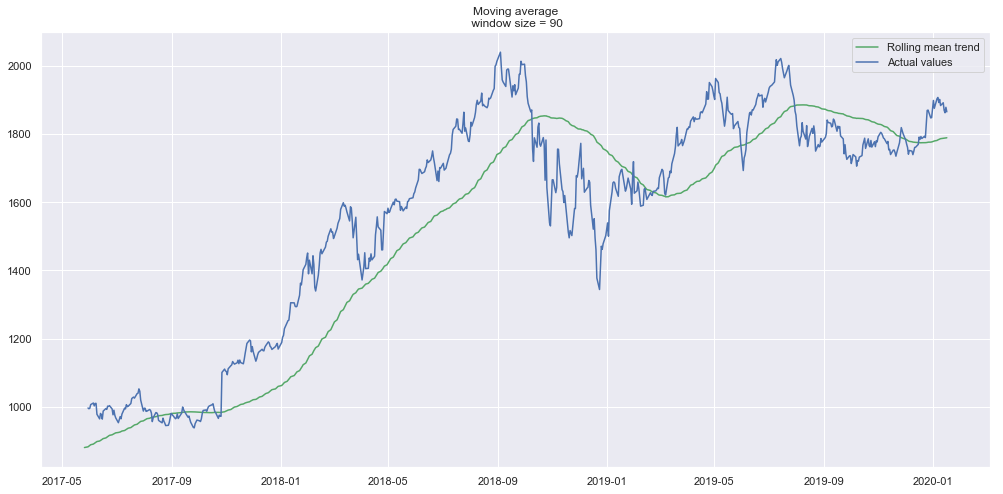

In [6]:
plot_moving_average(data.Close, 90)

Trends are easier to spot now. Notice how the 30-day and 90-day trend show a
downward curve at the end. This might mean that the stock is likely to go down in the
following days.

### Exponential smoothing
**Exponential smoothing** uses a similar logic to moving average, but this time, a different
decreasing weight is assigned to each observations. In other words, less importance is
given to observations as we move further from the present (very old observations become less important).

**Double exponential smoothing** is used when there is a trend in the time series. In that
case, we use this technique, which is simply a recursive use of exponential smoothing
twice.

**Triple exponential smoothing** extends double exponential smoothing, by adding a seasonal smoothing
factor. Of course, this is useful if you notice seasonality in your time series.

<br />
<center>
<img src="C:/Users/divya/ipynb.images/exponential-smoothing.png" width=400 />
</center>

$\alpha$ is a smoothing factor that takes values between 0 and 1. It determines how
fast the weight decreases for previous observations.

$\beta$ is the trend smoothing factor, and it takes values between 0 and 1.

$\gamma$ is the seasonal smoothing factor and L is the length of the season.

Let's do exponential smoothing and use 0.05 and 0.3 as values for the smoothing factor.

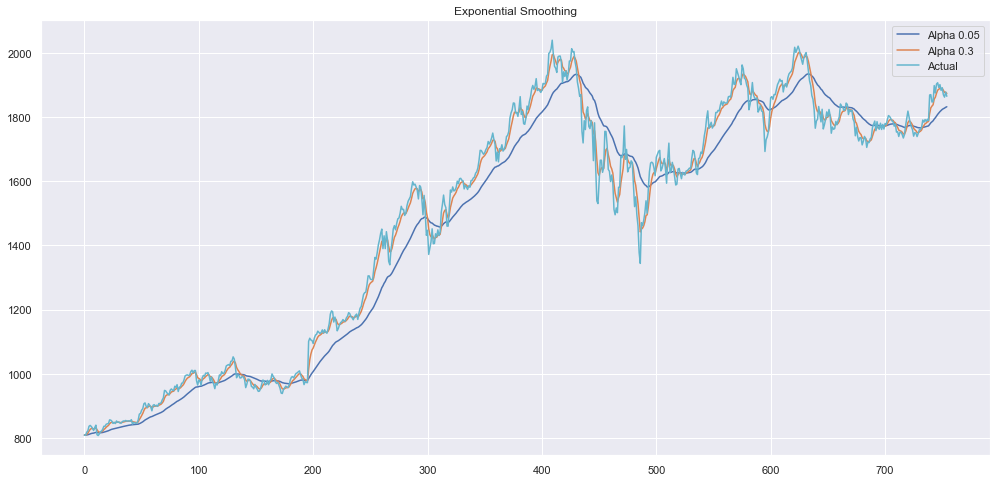

In [7]:
def exponential_smoothing(series, alpha):
    result = [series[0]] # first value is same as series
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return result

def plot_exponential_smoothing(series, alphas):
    plt.figure(figsize=(17, 8))
    for alpha in alphas:
        plt.plot(exponential_smoothing(series, alpha), label="Alpha {}".format(alpha))
    plt.plot(series.values, "c", label = "Actual")
    plt.legend(loc="best")
    plt.axis('tight')
    plt.title("Exponential Smoothing")
    plt.grid(True);
        
plot_exponential_smoothing(data.Close, [0.05, 0.3])

As you can see, an alpha value of 0.05 smoothed the curve while picking up most of the
upward and downward trends.

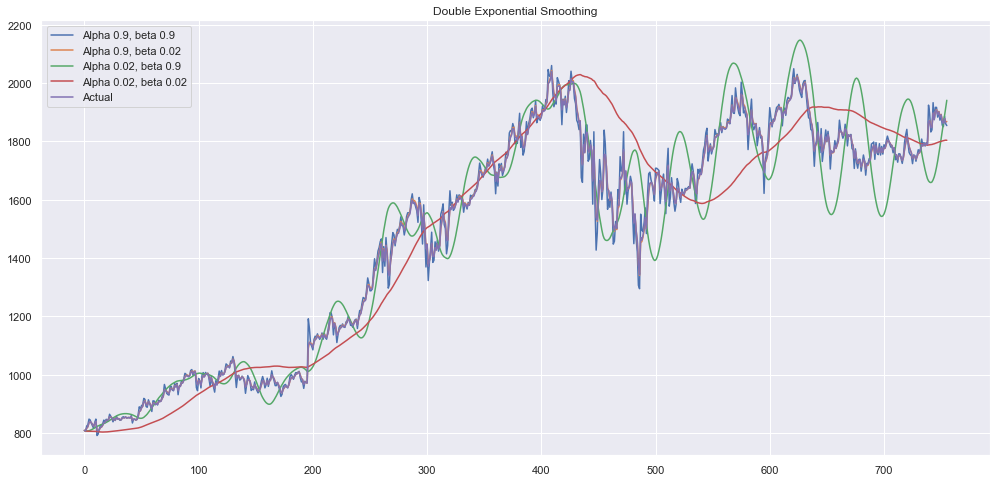

In [8]:
def double_exponential_smoothing(series, alpha, beta):
    result = [series[0]]
    
    for n in range(1, len(series)+1):
        if n == 1:
            level, trend = series[0], series[1] - series[0]
        if n >= len(series): # forecasting
            value = result[-1]
        else:
            value = series[n]
        
        last_level, level = level, alpha * value + (1 - alpha) * (level + trend)
        trend = beta * (level - last_level) + (1 - beta) * trend
        result.append(level + trend)
    return result

def plot_double_exponential_smoothing(series, alphas, betas):
    plt.figure(figsize=(17, 8))
    for alpha in alphas:
        for beta in betas:
            plt.plot(double_exponential_smoothing(series, alpha, beta), label="Alpha {}, beta {}".format(alpha, beta))
    plt.plot(series.values, label = "Actual")
    plt.legend(loc="best")
    plt.axis('tight')
    plt.title("Double Exponential Smoothing")
    plt.grid(True)

plot_double_exponential_smoothing(data.Close, alphas=[0.9, 0.02], betas=[0.9, 0.02])

### Modelling

We must turn our series into a **stationary process** in order to
model it. Therefore, let’s apply the Dickey-Fuller test to see if it is a stationary process. The Dickey-Fuller test is a point estimate, when it is tiny (say less than 0.01), we can safely say that the time series is stationary. Otherwise, *not*.

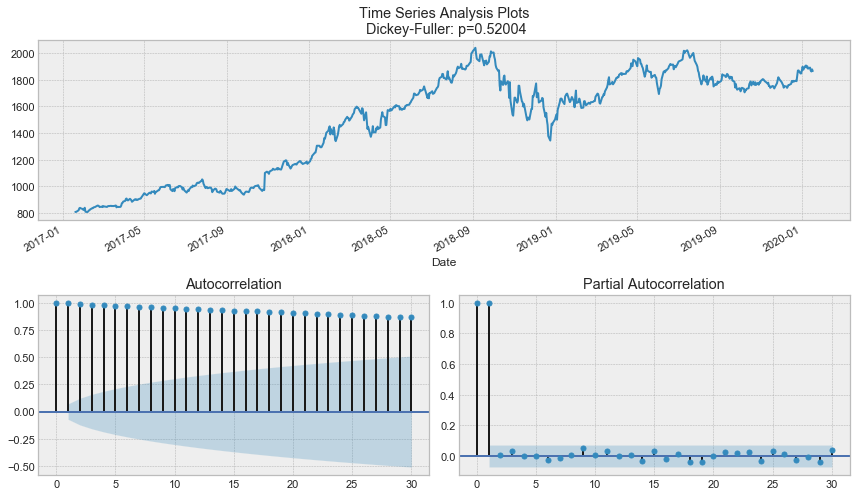

In [9]:
import statsmodels.api as sm
import statsmodels as smt

def tsplot(y, lags=None, figsize=(12, 7), syle='bmh'):
    
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
        
    with plt.style.context(style='bmh'):        
        fig = plt.figure(figsize=figsize)
        layout = (2,2)
        ts_ax = plt.subplot2grid(layout, (0,0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1,0))
        pacf_ax = plt.subplot2grid(layout, (1,1))
        
        y.plot(ax=ts_ax)
        p_value = sm.tsa.stattools.adfuller(y)[1]
        ts_ax.set_title('Time Series Analysis Plots\n Dickey-Fuller: p={0:.5f}'.format(p_value))
        smt.graphics.tsaplots.plot_acf(y, lags=lags, ax=acf_ax)
        smt.graphics.tsaplots.plot_pacf(y, lags=lags, ax=pacf_ax)
        plt.tight_layout()
        
tsplot(data.Close, lags=30)

By the Dickey-Fuller test, the time series is non-stationary. 

Also, looking at the autocorrelation plot, we see that it is very high, and it seems that there is no clear seasonality.

Therefore, to get rid of the high autocorrelation and to make the process stationary, let’s take the first difference: We simply subtract the time series from itself with a lag of one day, and we get:

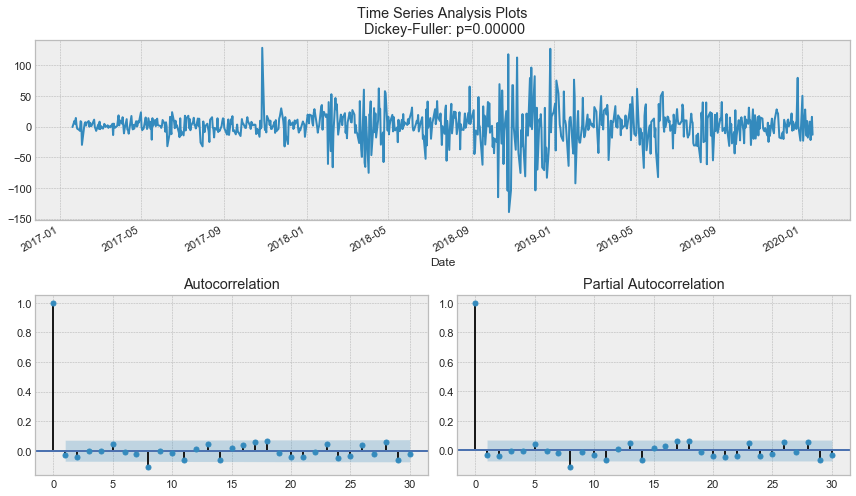

In [10]:
# Take the first difference to remove to make the process stationary
data_diff = data.Close - data.Close.shift(1)

tsplot(data_diff[1:], lags=30)

Our series is now stationary and we can start modelling! Does all this math make you want to work for Wall Street?

<br />
<center>
<img src="ipynb.images/wolf-wall-street.jpg" width=400 />
</center>

### Homework: 
Study the stationarity of **three** stocks from three different industries. Plot closing prices, model them with either simple or double exponential smoothing, and test to see if they're stationary.

# 8. Machine Learning with pandas & friends

Here we show an example of how well `Scikit-learn` and `pandas` integrate to do Machine Learning (`Scikit-learn`) from data (`pandas`). Don't worry about the algorithm yet ([random forest](https://en.wikipedia.org/wiki/Random_forest)), or Machine Learning (ML) in general. We'll study all this  in class. 

<br />
<center>
    <img src="ipynb.images/pretty-forest.jpeg" width=600 />
</center>

But random forests are so cool. In opinion, the most generally successful algorithm in ML. Invented in the 1950s (as a **decision tree** algorithm) and optimized using [ensembling](https://en.wikipedia.org/wiki/Ensemble_learning) in modern libraries like `Scikit-Learn`. Just be amazed ;-)

<br />
<center>
    <img src="ipynb.images/minions-amazed.jpg" width=300 />
</center>

We read in meterological data as a `pandas` dataframe:

In [54]:
import pandas as pd

Let's peek at our data..

In [55]:
data.head()

,Open,High,Low,Close
Date,,,,
2017-01-19,810.000000,813.510010,807.320007,809.039978
2017-01-20,815.280029,816.020020,806.260010,808.330017
2017-01-23,806.799988,818.500000,805.080017,817.880005
2017-01-24,822.000000,823.989990,814.500000,822.440002
2017-01-25,825.789978,837.419983,825.289978,836.520020


After a bit of EDA, we decide to do some data *healing* and preprocessing:

In [56]:
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
from sklearn.model_selection import train_test_split

Let's look at the attributes (columns) of our dataset.

In [57]:
data.columns

Index(['Open', 'High', 'Low', 'Close'], dtype='object')

In [58]:
 # Shift Close down to predict next day
pd.concat([data.Close, data.Close.shift(-282)], axis=1)

,Close,Close
Date,,
2017-01-19,809.039978,1523.609985
2017-01-20,808.330017,1537.640015
2017-01-23,817.880005,1545.000000
2017-01-24,822.440002,1551.859985
2017-01-25,836.520020,1578.890015
2017-01-26,839.150024,1598.390015
2017-01-27,835.770020,1588.180054
2017-01-30,830.380005,1591.000000
2017-01-31,823.479980,1582.319946


In [59]:
data.columns

Index(['Open', 'High', 'Low', 'Close'], dtype='object')

In [72]:
# Need to remove NA
# Regression - Try to predict Close (y) from non Close columns (X)
# Get training set (X_train)
def valid(col):
    return 'Date' not in col and 'Close' not in col
# we remove the last observation (last row) because there is no tomorrow for the last row to predict!
X = data[[x for x in data.columns if valid(x)]].iloc[:-282]

# for the dependent variable, we remove the NA, so that removes the last row, too
y = data.Close.shift(-282).dropna()

In [73]:
X.T

Date,2017-01-19 00:00:00,2017-01-20 00:00:00,2017-01-23 00:00:00,2017-01-24 00:00:00,2017-01-25 00:00:00,2017-01-26 00:00:00,2017-01-27 00:00:00,2017-01-30 00:00:00,2017-01-31 00:00:00,2017-02-01 00:00:00,...,2018-11-19 00:00:00,2018-11-20 00:00:00,2018-11-21 00:00:00,2018-11-23 00:00:00,2018-11-26 00:00:00,2018-11-27 00:00:00,2018-11-28 00:00:00,2018-11-29 00:00:00,2018-11-30 00:00:00,2018-12-03 00:00:00
Open,810.000000,815.280029,806.799988,822.00000,825.789978,835.530029,839.000000,833.000000,823.750000,829.210022,...,1577.010010,1437.50,1542.98999,1517.000000,1539.000000,1575.989990,1613.920044,1674.989990,1679.5,1769.459961
High,813.510010,816.020020,818.500000,823.98999,837.419983,843.840027,839.700012,833.500000,826.989990,833.780029,...,1581.189941,1534.75,1550.00000,1536.199951,1584.810059,1597.650024,1681.449951,1689.989990,1696.0,1778.339966
Low,807.320007,806.260010,805.080017,814.50000,825.289978,833.000000,829.440002,816.380005,819.559998,824.940002,...,1503.359985,1420.00,1515.00000,1501.810059,1524.219971,1558.010010,1601.219971,1652.329956,1666.5,1730.000000


In [74]:
y

Date
2017-01-19    1523.609985
2017-01-20    1537.640015
2017-01-23    1545.000000
2017-01-24    1551.859985
2017-01-25    1578.890015
2017-01-26    1598.390015
2017-01-27    1588.180054
2017-01-30    1591.000000
2017-01-31    1582.319946
2017-02-01    1571.680054
2017-02-02    1544.930054
2017-02-03    1586.510010
2017-02-06    1581.859985
2017-02-07    1544.920044
2017-02-08    1495.560059
2017-02-09    1555.859985
2017-02-10    1497.050049
2017-02-13    1431.420044
2017-02-14    1447.339966
2017-02-15    1371.989990
2017-02-16    1392.050049
2017-02-17    1410.569946
2017-02-21    1451.750000
2017-02-22    1405.229980
2017-02-23    1406.079956
2017-02-24    1436.219971
2017-02-27    1427.050049
2017-02-28    1448.500000
2017-03-01    1430.790039
2017-03-02    1441.500000
                 ...     
2018-10-22    1740.479980
2018-10-23    1751.599976
2018-10-24    1749.510010
2018-10-25    1739.209961
2018-10-26    1748.719971
2018-10-29    1760.329956
2018-10-30    1760.939941
2018-10

In [75]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

Now we create a ML model, using `RandomForestRegressor` from the `sk-learn` package. Do not worry if you don't understand how this is done. You will soon enough! 

That's *one* line of code in `Scikit-learn`.

Then, we fit the model to the training data (that's the ***training step***). That is where we fit a **curve** to the **datapoints**. This is where we do function approximation. We try to find the function that fits through our data.


That's *another* line of code in `Scikit-learn`.

Here are your two lines of code that do *everything*:

In [76]:
# Create a model 
rf_model = RandomForestRegressor()

# Train the model
rf_model.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [77]:
# Get R2 measure (indicator of accuracy 1 is perfect, 0 is horrible)
rf_model.score(X_test, y_test)

0.7083274175218012

Not bad, close to 85%! Let's plot predictions over actual values to see better:

In [91]:
y_pred = rf_model.predict(X_test)

In [92]:
type(y_pred)

numpy.ndarray

In [93]:
y_pred[0:10]

array([1619.2600099, 1743.0299924, 1527.5010133, 1798.3299805,
       1636.7130126, 1887.3119751, 1631.7459963, 1566.2160158,
       1994.2549927, 1721.424011 ])

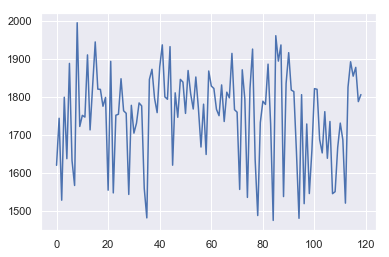

In [94]:
import matplotlib.pyplot as plt
plt.plot(y_pred)

We need to convert a pandas series to a numpy array:

In [95]:
type(y_test)

pandas.core.series.Series

In [96]:
y_test2 = y_test.as_matrix()
type(y_test2)

numpy.ndarray

In [97]:
y_test2[0:10]

array([1581.400024, 1723.790039, 1527.48999 , 1764.25    , 1633.      ,
       1917.77002 , 1575.390015, 1571.680054, 2012.709961, 1704.859985])

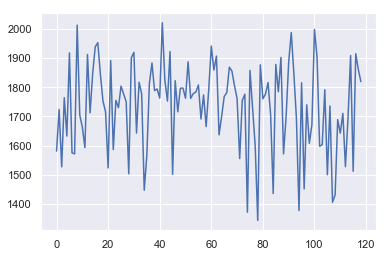

In [98]:
import matplotlib.pyplot as plt
plt.plot(y_test2)

Now let's plot predictions on top of test labels to see if we have a match. We'll plot one under the other and then reverse them to see if the mismatch is big or not:

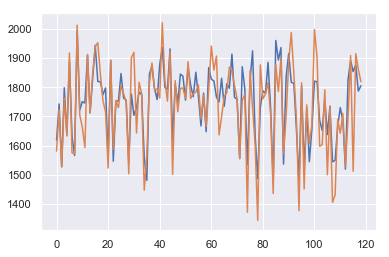

In [99]:
import matplotlib.pyplot as plt
plt.plot(y_pred)
plt.plot(y_test2)

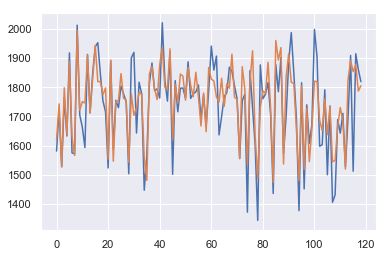

In [100]:
import matplotlib.pyplot as plt
plt.plot(y_test2)
plt.plot(y_pred)

Looks like a good match! Let's tabulate:

In [101]:
type(y_test)

pandas.core.series.Series

In [102]:
pd.concat([pd.Series(y_pred), y_test.reset_index(drop=True)], axis=1)

,0,Close
0,1619.260010,1581.400024
1,1743.029992,1723.790039
2,1527.501013,1527.489990
3,1798.329981,1764.250000
4,1636.713013,1633.000000
5,1887.311975,1917.770020
6,1631.745996,1575.390015
7,1566.216016,1571.680054
8,1994.254993,2012.709961
9,1721.424011,1704.859985


In [103]:
sorted(zip(X.columns, rf_model.feature_importances_),
        key=lambda x: x[1], reverse=True)

[('High', 0.39023414968731884),
 ('Low', 0.3738668072272955),
 ('Open', 0.2358990430853857)]